# Estimate Nelson-Siegel

The parameters are provided for Problem `2`.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
# import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [3]:
filepath = '../data/select_maturities_2017-02-07.xlsx'
quotes = pd.read_excel(filepath).set_index('kytreasno')
quotes['price'] = (quotes['bid'] + quotes['ask'])/2 + quotes['accrint']
quotes

,date,issue date,maturity date,ttm,bid,ask,accrint,ytm,duration,outstanding,cpn rate,instrument,price
kytreasno,,,,,,,,,,,,,
206525,2017-02-07,2012-08-31,2017-08-31,0.561259,99.945312,99.984375,0.276243,0.006830,0.559690,60995,0.625,2,100.241087
206589,2017-02-07,2013-02-28,2018-02-28,1.056810,99.835938,99.875000,0.331492,0.008865,1.051226,69708,0.750,2,100.186960
207005,2017-02-07,2016-08-31,2018-08-31,1.560575,99.531250,99.570312,0.331492,0.010370,1.549334,27778,0.750,2,99.882273
206708,2017-02-07,2014-02-28,2019-02-28,2.056126,100.570312,100.617188,0.662983,0.012044,2.019424,35097,1.500,2,101.256733
206767,2017-02-07,2014-08-31,2019-08-31,2.559890,100.710938,100.734375,0.718232,0.013312,2.500337,35002,1.625,2,101.440888
206823,2017-02-07,2015-02-28,2020-02-29,3.058179,99.718750,99.765625,0.607735,0.014560,2.987188,34999,1.375,2,100.349922
206887,2017-02-07,2015-08-31,2020-08-31,3.561944,99.218750,99.265625,0.607735,0.015868,3.466990,35000,1.375,2,99.849922
206947,2017-02-07,2016-02-29,2021-02-28,4.057495,97.664062,97.710938,0.497238,0.017102,3.956565,45395,1.125,2,98.184738
207007,2017-02-07,2016-08-31,2021-08-31,4.561259,97.031250,97.078125,0.497238,0.017916,4.434572,36326,1.125,2,97.551925


Consider the bootstrap function used in `Homework 4`:

In [4]:
def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)

In [5]:
COMPOUNDING = 2

spot = pd.DataFrame(bootstrap_spot_rates(quotes))
spot.columns = ['rate']
spot['discount factor'] = intrate_to_discount(spot['rate'],spot.index,n_compound=COMPOUNDING)

In [6]:
spot

,rate,discount factor
0.561259,0.001425,0.999201
1.056810,0.005623,0.994084
1.560575,0.008291,0.987170
2.056126,0.008648,0.982413
2.559890,0.010396,0.973805
3.058179,0.012558,0.962440
3.561944,0.014191,0.950878
4.057495,0.015953,0.937564
4.561259,0.016923,0.926015
5.056810,0.017189,0.917090


## Nelson-Siegel

In [7]:
raw = quotes.copy()
raw.rename(columns={'cpn rate':'TCOUPRT','date':'CALDT','maturity date':'TMATDT'},inplace=True)
CF = calc_cashflows(raw)

In [8]:
t_current = quotes['date'].iloc[0]

x0 = np.ones((4,))/7
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,quotes['price'],x0)

In [9]:
x0 = np.concatenate((params_NS,(1,1)))
params_NSE = estimate_rate_curve(nelson_siegel_extended,CF,t_current,quotes['price'],x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
tab_params_ns

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.031627,-0.025166,-0.020701,1.514887,None,None
Nelson-Siegel Extended,0.026081,-0.020535,0.206525,3.306510,-0.193406,3.098733


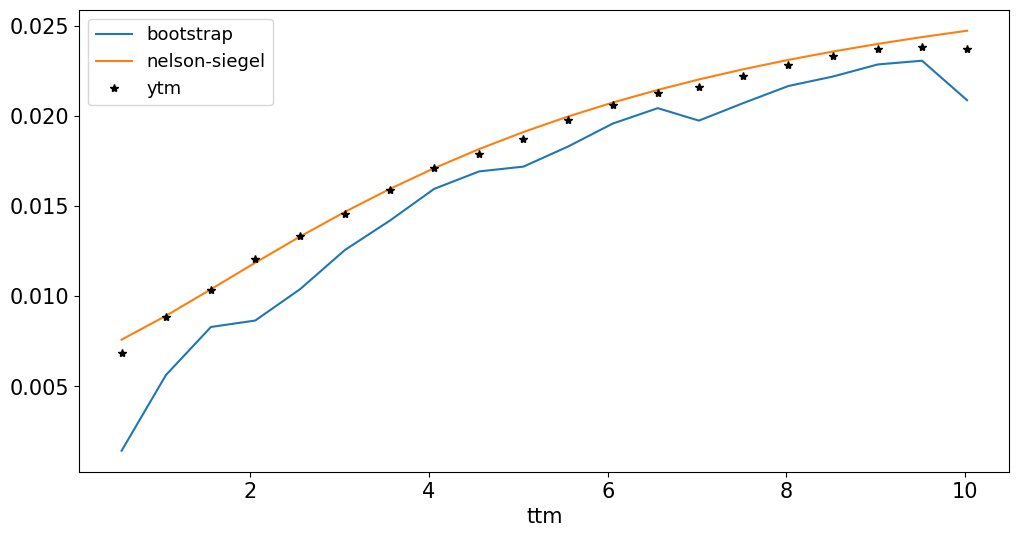

In [10]:
tab = spot[['rate']].copy()
tab.columns = ['bootstrap']
tab['nelson-siegel'] = nelson_siegel(params_NS,spot.index)
ax = tab.plot();
(quotes[['ttm','ytm']].set_index('ttm')).plot(ax=ax,linestyle='',marker='*',color='k');

In [12]:
params_NS

array([ 0.03162653, -0.02516637, -0.02070145,  1.51488729])